In [1]:
"""
model: Neural Language Models (Bengio et al. 2003) URL: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Dimension key:
# windows
B: batch size
T: sequence length

# input/output
V: vocabulary size
E: embedding dimension
D: model dimension
"""
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# from jaxtyping import ...
g = torch.Generator().manual_seed(1337) # for .randn()

B, T = 32, 3
V, E, D = 27, 10, 200

# step: 0/200000, loss 27.63208770751953
# -> expected loss = nll = p(c) = -torch.tensor(1/V=27).log() = 3.2958
# -> self.W = torch.randn() is sampling from N(0, 1)
# -> self.W * [gain/sqrt(D_in)] (torch.init_kaimingnormal())

# residuals + normalization + Adam/RMSprop has made initialization less fragile
# -> b/c initialization is fragile/intractable with *deep* neural networks

class Linear:
    def __init__(self, D_in, D_out, bias=True):
        self.W_DiDo = torch.randn((D_in, D_out), generator=g) * (5/3)/D_in**0.5 # kaiming init (He et al. 2015)
        self.b_Do = torch.zeros(D_out) if bias else None

    def __call__(self, X_Di):
        self.X_Do = X_Di @ self.W_DiDo
        if self.b_Do is not None:
            self.X_Do += self.b_Do
        self.out = self.X_Do
        return self.X_Do

    def parameters(self):
        return [self.W_DiDo] + ([] if self.b_Do is None else [self.b_Do])

class BatchNorm1D:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
    def __call__(self, X_BD):
        self.X_BD = torch.tanh(X_BD)
        # plt.hist(self.X_BD.view(-1).tolist(), 50); # distribution of weights
        # plt.imshow(self.X_BD.abs() > 0.99, cmap='gray', interpolation='nearest') # vanishing gradients
        self.out = self.X_BD
        return self.X_BD
    
    def parameters(self):
        return []

model = [
    Linear(T * E, D, bias=False), BatchNorm1D(D), Tanh(),
    Linear(D, D, bias=False), BatchNorm1D(D), Tanh(),
    Linear(D, V, bias=False), BatchNorm1D(V)
]

C = torch.randn((V,E), generator=g)
params = [C] + [p for l in model for p in l.parameters()]
for p in params:
    p.requires_grad = True

step: 0/200000, loss 3.811568260192871
step: 10000/200000, loss 2.625439405441284
step: 20000/200000, loss 2.426504135131836
step: 30000/200000, loss 1.8564293384552002
step: 40000/200000, loss 2.563091993331909
step: 50000/200000, loss 1.8718260526657104
step: 60000/200000, loss 2.189483642578125
step: 70000/200000, loss 1.9642211198806763
step: 80000/200000, loss 2.261333465576172
step: 90000/200000, loss 2.2367687225341797
step: 100000/200000, loss 1.7542214393615723
step: 110000/200000, loss 1.9069358110427856
step: 120000/200000, loss 2.2940409183502197
step: 130000/200000, loss 2.030090808868408
step: 140000/200000, loss 2.556252956390381
step: 150000/200000, loss 2.0693819522857666
step: 160000/200000, loss 2.2053565979003906
step: 170000/200000, loss 2.3926899433135986
step: 180000/200000, loss 2.4394421577453613
step: 190000/200000, loss 2.0519824028015137


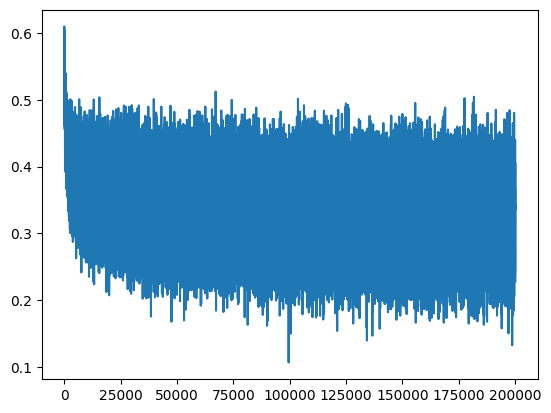

In [2]:
# 1. dataloader
import torch.nn.functional as F
import random

words = open('./data/names.txt', 'r').read().splitlines()
v = sorted(list(set(''.join(words))))
encode = { c:i+1 for i,c in enumerate(v) }
encode['.'] = 0
decode = { i:c for c,i in encode.items() }

def gen_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * T;
        for c in w + '.':
            X.append(context)
            Y.append(encode[c])
            # print(''.join(decode[i] for i in context), '-->', decode[encode[c]])
            context = context[1:] + [encode[c]]
    X, Y = torch.tensor(X), torch.tensor(Y) # X:(N,C) Y:(N)
    return X, Y

random.seed(42)
random.shuffle(words)
n1, n2 = int(0.8*len(words)), int(0.9*len(words))
Xtr, Ytr = gen_dataset(words[:n1])
Xdev, Ydev = gen_dataset(words[n1:n2])
Xte, Yte = gen_dataset(words[n2:])

# 2. training loop
N = Xtr.shape[0]
losses, steps = [], []
for step in range(200000):
    # 1. forward
    indices_B = torch.randint(0, N, (B,))
    X_B, Y_B = Xtr[indices_B], Ytr[indices_B]

    X_BD = C[X_B].view(-1, T * E)
    for layer in model:
        X_BD = layer(X_BD)
    loss = F.cross_entropy(X_BD, Y_B)

    # 2. backward
    for layer in model:
        layer.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()

    # 3. update
    for p in params:
        p.data += -0.01 * p.grad

    steps.append(step)
    losses.append(loss.log10().item())
    if step % 10000 == 0:
        print(f"step: {step}/{200000}, loss {loss.item()}")

plt.plot(steps, losses)

In [3]:
# inference loop
for layer in model:
  if isinstance(layer, BatchNorm1D):
      layer.training = False

token_terminal = 0
for _ in range(20):
  output, context = [], [0] * T
  while True:
      emb = C[torch.tensor([context])]
      X_BD = emb.view(emb.shape[0], -1)
      for layer in model:
        X_BD = layer(X_BD)
      logits = X_BD
      probs = F.softmax(logits, dim=1)

      token = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
      context = context[1:] + [token]
      output.append(decode[token])
      if token == token_terminal:
          break
  print(''.join(output))

len.
roguzten.
bria.
esaberlie.
kaliah.
fawoaswyus.
ina.
aire.
guriina.
cartieon.
uria.
timus.
wilmi.
fere.
dhan.
kynli.
mediyra.
leightitie.
domeya.
aur.
